In [1]:
import os

if not os.path.exists('./SDOBenchmark-data-full'):
    !curl -L -o ./dataset.zip https://github.com/i4Ds/SDOBenchmark/archive/refs/heads/data-full.zip
    !unzip -q ./dataset.zip
    !mv SDOBenchmark-data-full* SDOBenchmark-data-full


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pathlib import Path
import pandas as pd

DATA_ROOT = Path("SDOBenchmark-data-full")
THRESHOLD = 1e-5  # M/X threshold

# Read both CSVs
train_meta = pd.read_csv(DATA_ROOT / "training/meta_data.csv")
test_meta  = pd.read_csv(DATA_ROOT / "test/meta_data.csv")

# Keep only severe rows
train_severe = train_meta[train_meta["peak_flux"] >= THRESHOLD].copy()
test_severe  = test_meta[test_meta["peak_flux"]  >= THRESHOLD].copy()

def split_id(id_str: str):
    s = str(id_str)
    # '11401_2012_01_16_04_53_01_0' -> ('11401', '2012_01_16_04_53_01_0')
    first_us = s.find("_")
    if first_us == -1:
        return s, ""  # fallback
    return s[:first_us], s[first_us+1:]

train_severe[["ar_id","time_folder"]] = train_severe["id"].apply(lambda x: pd.Series(split_id(x)))
test_severe[["ar_id","time_folder"]]  = test_severe["id"].apply(lambda x: pd.Series(split_id(x)))

print(train_severe[["id","ar_id","time_folder"]].head(3))
print(test_severe[["id","ar_id","time_folder"]].head(3))


                              id  ar_id            time_folder
93   11401_2012_01_17_19_12_01_0  11401  2012_01_17_19_12_01_0
94   11401_2012_01_17_19_12_01_1  11401  2012_01_17_19_12_01_1
103  11401_2012_01_16_04_53_01_0  11401  2012_01_16_04_53_01_0
                            id  ar_id            time_folder
7  11402_2012_01_27_04_26_00_0  11402  2012_01_27_04_26_00_0
8  11402_2012_01_27_04_26_00_1  11402  2012_01_27_04_26_00_1
9  11402_2012_01_18_16_05_01_0  11402  2012_01_18_16_05_01_0


In [4]:
# Check a few paths exist
def exists_count(df, split):
    cnt = 0
    for _, r in df.iterrows():
        p = DATA_ROOT / split / str(r["ar_id"]) / str(r["time_folder"])
        if p.exists():
            cnt += 1
    return cnt

exist_train = exists_count(train_severe, "training")
exist_test  = exists_count(test_severe, "test")

print(f"Training severe rows: {len(train_severe)} | folders found: {exist_train}")
print(f"Test severe rows:     {len(test_severe)}  | folders found: {exist_test}")


Training severe rows: 514 | folders found: 514
Test severe rows:     176  | folders found: 176


In [5]:
from pathlib import Path
import shutil

DEST_DIR  = Path("./severe cases") 
DEST_DIR.mkdir(parents=True, exist_ok=True)

IMAGE_EXTS = {".jpg",".jpeg",".png",".tif",".tiff",".bmp",".gif"}

def copy_folder_images(base_dir: Path, split: str) -> int:
    """Copy all images under base_dir (including subfolders)."""
    copied = 0
    # rglob catches images even if there are subfolders
    for img in base_dir.rglob("*"):
        if img.is_file() and img.suffix.lower() in IMAGE_EXTS:
            parent = img.parent.name  # time-folder (or subfolder)
            dest_name = f"{split}__{base_dir.parent.name}__{base_dir.name}__{img.name}"
            dest_path = DEST_DIR / dest_name
            if not dest_path.exists():
                shutil.copy2(img, dest_path)
                copied += 1
    return copied

total = 0

# training
for _, r in train_severe.iterrows():
    src = DATA_ROOT / "training" / str(r["ar_id"]) / str(r["time_folder"])
    if src.exists():
        total += copy_folder_images(src, "training")

# test
for _, r in test_severe.iterrows():
    src = DATA_ROOT / "test" / str(r["ar_id"]) / str(r["time_folder"])
    if src.exists():
        total += copy_folder_images(src, "test")  

print(f"✅ Done! Copied {total} images to: {DEST_DIR}")


✅ Done! Copied 27276 images to: severe cases


In [6]:
files = list(DEST_DIR.iterdir())
print("Files collected:", len(files))
for f in files[:10]:
    print(f.name)


Files collected: 27287
AIA_131
AIA_1700
AIA_171
AIA_193
AIA_211
AIA_304
AIA_335
AIA_94
HMI_continuum
HMI_magnetogram


In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Folder where images were collected
SEVERE_DIR = Path("severe cases")

# List all image files
image_files = [p for p in SEVERE_DIR.glob("*") if p.suffix.lower() in (".jpg",".jpeg",".png",".tif",".tiff",".bmp")]

print(f"Total severe images found: {len(image_files)}")


Total severe images found: 27276


In [9]:
from pathlib import Path
import shutil, re
from collections import Counter

# ---- config (can be overridden from your snippet) ----
SEVERE_DIR = Path("severe cases")
MODE = "move"       # "move", "copy", or "symlink"
DRY_RUN = False     # True = only report, don’t touch files
IMG_EXTS = {".jpg",".jpeg",".png",".tif",".tiff",".bmp"}

# wavelength patterns
AIA_BANDS = ["131","1700","171","193","211","304","335","94"]
# robust: match band tokens not embedded in other numbers/words (e.g., 1700 won't match 17000)
AIA_REGEX = re.compile(r"(?<!\d)(131|1700|171|193|211|304|335|94)(?!\d)", re.IGNORECASE)

# HMI variants (account for typos/abbrev)
HMI_CONT_REGEX = re.compile(r"continuum", re.IGNORECASE)
HMI_MAG_REGEX  = re.compile(r"(magnetogram|magneto?g?ram|mag)", re.IGNORECASE)

def infer_band_from_name(name: str) -> str | None:
    """Return canonical subfolder name like 'AIA_171' or 'HMI_magnetogram'."""
    n = name.lower()
    # HMI first (so 'mag' in names doesn't get mistaken for numbers)
    if HMI_CONT_REGEX.search(n):
        return "HMI_continuum"
    if HMI_MAG_REGEX.search(n):
        return "HMI_magnetogram"
    m = AIA_REGEX.search(n)
    if m:
        return f"AIA_{m.group(1)}"
    return None

def _place(src: Path, dst_dir: Path):
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst = dst_dir / src.name
    if DRY_RUN:
        return
    if MODE == "move":
        # fast rename if same filesystem
        src.replace(dst)
    elif MODE == "copy":
        if not dst.exists():
            shutil.copy2(src, dst)
    elif MODE == "symlink":
        if not dst.exists():
            try:
                rel = src.relative_to(dst_dir)
            except Exception:
                rel = src
            dst.symlink_to(rel)
    else:
        raise ValueError("MODE must be one of: 'move', 'copy', 'symlink'.")

def sort_severe_images(root: Path | str = SEVERE_DIR,
                       mode: str = MODE,
                       dry_run: bool = DRY_RUN,
                       verbose: bool = True):
    """
    Scan severe cases directory, infer wavelength from filename, and move/copy/symlink
    into per-band subfolders. Returns (counts, unmatched_list).
    """
    global MODE, DRY_RUN
    MODE, DRY_RUN = mode, dry_run

    root = Path(root)
    counts = Counter()
    unmatched = []

    files = [p for p in root.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
    if verbose:
        print(f"[info] scanning {len(files)} image files in: {root}")
        if dry_run: print("[info] dry-run mode: no files will be modified")

    for p in files:
        band = infer_band_from_name(p.name)
        if band is None:
            unmatched.append(p.name)
            continue
        _place(p, root / band)
        counts[band] += 1

    if verbose:
        print("\n=== sort summary ===")
        for k in sorted(counts):
            print(f"{k:>18}: {counts[k]}")
        print(f"unmatched files: {len(unmatched)}")
        if unmatched[:10]:
            print("examples:", unmatched[:10])
        print(f"mode: {mode.upper()}  | dry-run: {dry_run}")

    return counts, unmatched


In [10]:
# 1) just see what would happen (no moves yet):
sort_severe_images(dry_run=True)

# 2) actually move files into per-wavelength folders:
sort_severe_images(mode="move", dry_run=False)

# 3) prefer copying instead of moving:
sort_severe_images(mode="copy")

# 4) create space-saving symlinks:
sort_severe_images(mode="symlink")


[info] scanning 27276 image files in: severe cases
[info] dry-run mode: no files will be modified

=== sort summary ===
           AIA_131: 2735
          AIA_1700: 2718
           AIA_171: 2722
           AIA_193: 2740
           AIA_211: 2741
           AIA_304: 2741
           AIA_335: 2730
            AIA_94: 2739
     HMI_continuum: 2705
   HMI_magnetogram: 2705
unmatched files: 0
mode: MOVE  | dry-run: True
[info] scanning 27276 image files in: severe cases

=== sort summary ===
           AIA_131: 2735
          AIA_1700: 2718
           AIA_171: 2722
           AIA_193: 2740
           AIA_211: 2741
           AIA_304: 2741
           AIA_335: 2730
            AIA_94: 2739
     HMI_continuum: 2705
   HMI_magnetogram: 2705
unmatched files: 0
mode: MOVE  | dry-run: False
[info] scanning 0 image files in: severe cases

=== sort summary ===
unmatched files: 0
mode: COPY  | dry-run: False
[info] scanning 0 image files in: severe cases

=== sort summary ===
unmatched files: 0
mode: S

(Counter(), [])

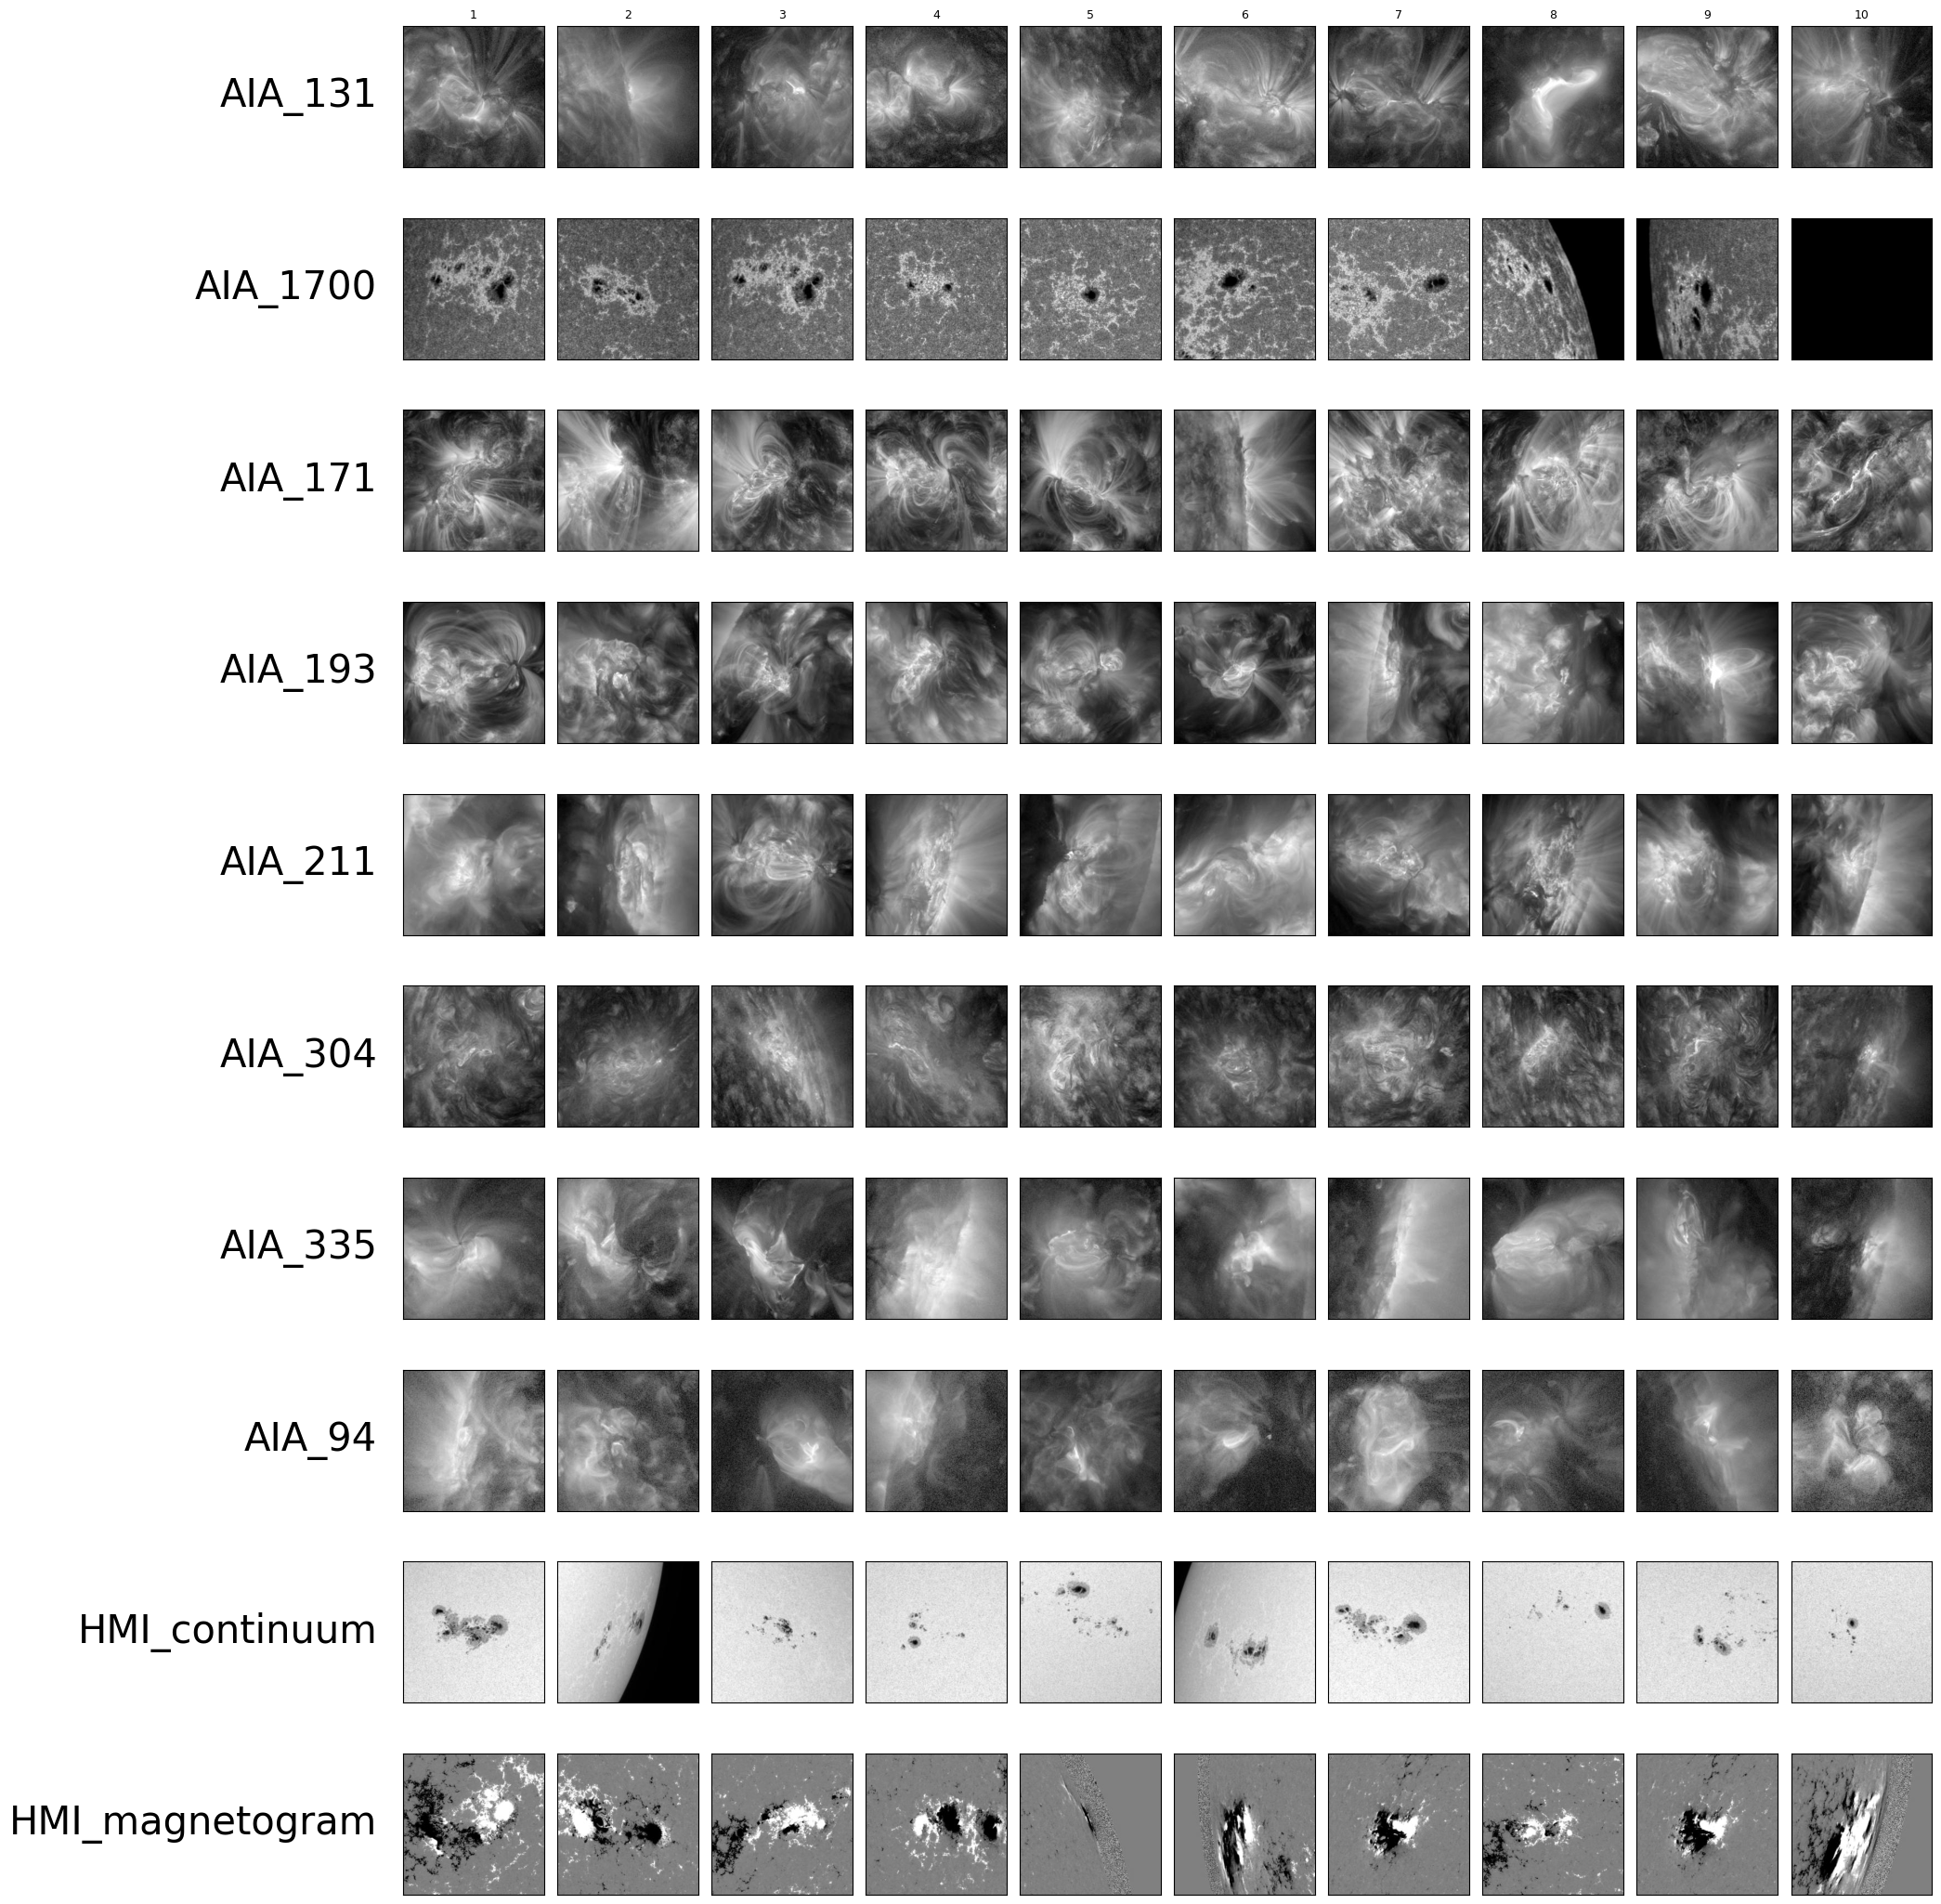

In [11]:
from pathlib import Path
import random, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

SEVERE_DIR = Path("severe cases")

# --- wavelength order we want to show (rows) ---
BANDS_ORDER = [
    "AIA_131","AIA_1700","AIA_171","AIA_193","AIA_211","AIA_304","AIA_335","AIA_94",
    "HMI_continuum","HMI_magnetogram",
]

IMG_EXTS = {".jpg",".jpeg",".png",".tif",".tiff",".bmp"}

# --- robust band inference from filename (works even if not sorted) ---
AIA_REGEX = re.compile(r"(?<!\d)(131|1700|171|193|211|304|335|94)(?!\d)", re.IGNORECASE)
HMI_CONT_REGEX = re.compile(r"continuum", re.IGNORECASE)
HMI_MAG_REGEX  = re.compile(r"(magnetogram|magneto?g?ram|mag)", re.IGNORECASE)

def infer_band_from_name(name: str):
    n = name.lower()
    if HMI_CONT_REGEX.search(n): return "HMI_continuum"
    if HMI_MAG_REGEX.search(n):  return "HMI_magnetogram"
    m = AIA_REGEX.search(n)
    if m: return f"AIA_{m.group(1)}"
    return None

# --- gather files per band (supports both flat and subfolder structures) ---
files_per_band = {b: [] for b in BANDS_ORDER}

# search recursively to be safe
for p in SEVERE_DIR.rglob("*"):
    if not (p.is_file() and p.suffix.lower() in IMG_EXTS):
        continue
    band = infer_band_from_name(p.name) or infer_band_from_name(str(p.parent.name))
    if band in files_per_band:
        files_per_band[band].append(p)

# --- plot: 10 columns per row (or fewer if not enough images) ---
cols = 10
rows = len(BANDS_ORDER)
fig, axes = plt.subplots(rows, cols, figsize=(cols*2.1, rows*2.1))
if rows == 1:  # safety if only one band found
    axes = np.array([axes])

for r, band in enumerate(BANDS_ORDER):
    candidates = files_per_band[band]
    if not candidates:
        # hide row if nothing found
        for c in range(cols):
            axes[r, c].axis('off')
        axes[r, 0].set_ylabel(band, rotation=0, ha='right', va='center', fontsize=10, labelpad=20)
        continue

    sample = random.sample(candidates, min(cols, len(candidates)))
    # fill up to 10 slots; empty axes if not enough images
    for c in range(cols):
        ax = axes[r, c]
        if c < len(sample):
            img_path = sample[c]
            # robust read (handles grayscale / 16-bit tif)
            try:
                im = Image.open(img_path)
                arr = np.array(im)
            except Exception:
                ax.axis('off'); continue

            if arr.ndim == 2:  # grayscale
                ax.imshow(arr, cmap='gray')
            else:
                ax.imshow(arr)
            ax.set_xticks([]); ax.set_yticks([])
            if r == 0:
                ax.set_title(f"{c+1}", fontsize=9)  # simple column index label
        else:
            ax.axis('off')

    # row label on the left
    axes[r, 0].set_ylabel(band, rotation=0, ha='right', va='center', fontsize=30, labelpad=20)

plt.tight_layout()
plt.show()


In [12]:
pip uninstall torch torchvision torchaudio -y


Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 53.8 MB/s  0:00:06:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 170.7 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 162.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [torchaudio]3 [torchaudio]]
Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch

def check_gpu():
    if torch.cuda.is_available():
        print("gpu is available!")
        print(f"gpu name: {torch.cuda.get_device_name(0)}")
        print(f"cuda version: {torch.version.cuda}")
    else:
        print("gpu is not available.")
        print("this might be because torch was installed without cuda support or the gpu drivers aren't configured correctly.")

if __name__ == "__main__":
    check_gpu()

gpu is available!
gpu name: Tesla T4
cuda version: 12.1
